In [1]:
import numpy as np
IMAGE_SIZE = 148
IMAGE_ROW = 64
IMAGE_COL = 64
Z_DIM = 128
ENCODER_FILTER_NUM = 32
IMAGE_CHANNELS = 3

# DATA_PATH = os.getenv("ANALYTICS_ZOO_HOME") + "/apps/variational_autoencoder/img_align_celeba"
DATA_PATH = "/home/wangzhiqi/data/datasets/img_align_celeba/img_align_celeba"
VGG_PATH = "/home/wangzhiqi/data/models/bigdl_vgg-16_imagenet_0.4.0.model"

from zoo.pipeline.api.keras.layers import *
from zoo.pipeline.api.keras.models import Model,Sequential
from zoo.pipeline.api.keras.utils import *
import zoo.pipeline.api.autograd as Z
from utils import *
from glob import glob
from zoo.pipeline.api.net import Net

def conv_bn_lrelu(out_channles, in_channels, in_row, in_col,kw=4, kh=4, sw=2, sh=2):
    input0 = Input(shape=(in_channels,in_row,in_col))
    conv1 = Convolution2D(out_channles, kw, kh, subsample=(sw, sh), border_mode='same')(input0)
    batch = BatchNormalization(out_channles)(conv1)
    relu = LeakyReLU(0.2)(batch)
    model = Model([input0], [relu])
    return model
    # model = Sequential()
    # model.add(Convolution2D(out_channles, kw, kh, subsample=(sw,sh),input_shape=(),border_mode='same'))
    # model.add(BatchNormalization(out_channles))
    # model.add(LeakyReLU(0.2))


def get_encoder_cnn():
    input0 = Input(shape=(IMAGE_CHANNELS, IMAGE_ROW, IMAGE_COL))
    conv1 = conv_bn_lrelu(ENCODER_FILTER_NUM, IMAGE_CHANNELS, IMAGE_ROW, IMAGE_COL)(input0)  # 32 * 32 * 32
    conv2 = conv_bn_lrelu(ENCODER_FILTER_NUM * 2,ENCODER_FILTER_NUM, 32, 32)(conv1)  # 16 * 16 * 64
    conv3 = conv_bn_lrelu(ENCODER_FILTER_NUM * 4,ENCODER_FILTER_NUM * 2, 16, 16)(conv2)  # 8 * 8 * 128
    conv4 = conv_bn_lrelu(ENCODER_FILTER_NUM * 8, ENCODER_FILTER_NUM * 4, 8, 8)(conv3)  # 4 * 4 * 256
    flatten = Flatten()(conv4)
    inter = Dense(2048)(flatten)
    inter = Reshape((1,1,2048))(inter)
    inter = BatchNormalization()(inter)
    inter = Flatten()(inter)
    inter = Activation('relu')(inter)
    
    mean = Dense(Z_DIM)(inter)
    log_variance = Dense(Z_DIM)(inter)

    model = Model([input0], [mean, log_variance])
    return model

def upsample_conv_bn_lrelu(out_channles, in_channels, in_row, in_col, out_width, out_height, kw=3, kh=3, sw=1, sh=1):
    input0 = Input(shape=(in_channels,in_col,in_row))
    resize = ResizeBilinear(out_width, out_height)(input0)
    conv1 = Convolution2D(out_channles, kw, kh, subsample=(sw, sh), border_mode='same')(resize)
    batch1 = BatchNormalization(out_channles)(conv1)
    relu = LeakyReLU(0.2)(batch1)
    model = Model([input0], [relu])
    return model


    #
    # model = Sequential()
    # model.add(ResizeBilinear(out_width, out_height, input_shape=(in_channels,in_col,in_row)))
    # model.add(Convolution2D(out_channles, kw, kh, subsample=(sw, sh),border_mode='same'))
    # model.add(BatchNormalization(out_channles))
    # model.add(LeakyReLU(0.2))
    # return model

def get_decoder_cnn():
    input0 = Input(shape=(Z_DIM,))
    linear = Dense(2048)(input0)
    linear = Dense(4 * 4 * ENCODER_FILTER_NUM * 8)(linear)
    reshape = Reshape((ENCODER_FILTER_NUM * 8, 4, 4))(linear)
    bn = BatchNormalization(ENCODER_FILTER_NUM * 8)(reshape)

    # upsampling
    up1 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM * 4,ENCODER_FILTER_NUM * 8, 4, 4, 8, 8)(bn)  # 8 * 8 * 128
    up2 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM * 2,ENCODER_FILTER_NUM * 4, 8, 8, 16, 16)(up1)  # 16 * 16 * 64
    up3 = upsample_conv_bn_lrelu(ENCODER_FILTER_NUM, ENCODER_FILTER_NUM * 2, 16, 16, 32, 32)(up2)  # 32 * 32 * 32
    up4 = upsample_conv_bn_lrelu(IMAGE_CHANNELS, ENCODER_FILTER_NUM, 32,32, 64, 64)(up3)  # 64 * 64 * 3
    output = Activation('sigmoid')(up4)

    model = Model([input0], [output])
    return model

def get_autoencoder_cnn():
    input0 = Input(shape=(IMAGE_CHANNELS, IMAGE_ROW, IMAGE_COL))
    encoder = get_encoder_cnn()(input0)
    sampler = GaussianSampler()(encoder)

    decoder_model = get_decoder_cnn()
    decoder = decoder_model(sampler)
    model = Model([input0], [encoder, decoder])
    return model, decoder_model

autoencoder, decoder_model = get_autoencoder_cnn()

def get_vgg():
    vgg_whole = Net.load_bigdl(VGG_PATH)

    # outputs = [vgg_whole.node(name) for name in ["relu1_2"]]
    # inputs = [vgg_whole.node(name) for name in ["data"]]
    #
    # outputs[0].remove_next_edges()
    # vgg_light = Model(inputs, outputs).freeze()
    vgg_light = vgg_whole.new_graph(["relu1_2"])
    vgg_light.freeze()
    return vgg_light

vgg = get_vgg()
print("Get VGG Model")





creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasBatchNormalization
creating: createZooKerasLeakyReLU
creating: createZooKerasModel
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasBatchNormalization
creating: createZooKerasLeakyReLU
creating: createZooKerasModel
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasBatchNormalization
creating: createZooKerasLeakyReLU
creating: createZooKerasModel
creating: createZooKerasInput
creating: createZooKerasConvolution2D
creating: createZooKerasBatchNormalization
creating: createZooKerasLeakyReLU
creating: createZooKerasModel
creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasReshape
creating: createZooKerasBatchNormalization
creating: createZooKerasFlatten
creating: createZooKerasActivation
creating: createZooKerasDense
creati

In [2]:
from pyspark import SparkContext
sc =SparkContext.getOrCreate()

def get_data():
    data_files = glob(os.path.join(DATA_PATH, "*.jpg"))

    rdd_train_images = sc.parallelize(data_files[:50000]) \
        .map(lambda path: inverse_transform(get_image(path, IMAGE_SIZE)).transpose(2, 0, 1))
    rdd_train_sample = rdd_train_images.map(lambda img: Sample.from_ndarray(img, [np.array(0.0), img]))
    return rdd_train_sample



train_data = get_data()

batch_size = 64
criterion = ParallelCriterion()
criterion.add(KLDCriterion(), 0.005) # You may want to twick this parameter
criterion.add(TransformerCriterion(MSECriterion(), vgg, vgg), 1.0)

autoencoder.compile(optimizer=Adam(0.001), loss=criterion)

autoencoder.fit(x=train_data,
                batch_size=batch_size,
                nb_epoch = 6)


creating: createParallelCriterion
creating: createKLDCriterion
creating: createMSECriterion
creating: createTransformerCriterion
creating: createAdam


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


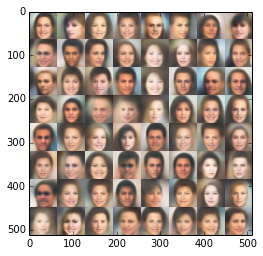

In [3]:
def gen_image_row():
    return np.column_stack([decoder_model.forward(np.random.randn(1, Z_DIM)).reshape(3, 64,64).transpose(1, 2, 0) for s in range(8)])

def gen_image():
    return np.row_stack([gen_image_row() for i in range(8)])





import matplotlib
matplotlib.use('Agg')
%pylab inline

from matplotlib.pyplot import imshow
img = gen_image()
imshow(img)
